## Масликов Дмитрий МСМТ231

In [1]:
# !pip install networkx==2.8.7
# !pip install scipy==1.8
# !pip install matplotlib==3.5.1
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import matplotlib.pylab as pylab

Используется следующий граф: https://networkrepository.com/fb-pages-government.php

In [2]:
G = nx.read_edgelist('fb-pages-government/fb-pages-government.edges', delimiter=',')

## Основные структурные свойства

### Число вершин, число ребер и плотность сети. Визуализация сети.

In [4]:
print('Nodes:', G.number_of_nodes()) 
print('Edges:', G.number_of_edges())
print('Density:', nx.density(G)) 

Nodes: 7057
Edges: 89455
Density: 0.003592989318914945


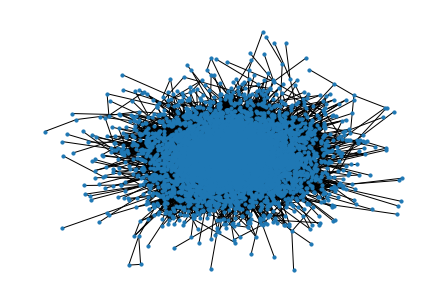

In [7]:
pos = nx.spring_layout(G, iterations=10)
nx.draw(G, pos=pos, node_size=10, with_labels=False)

#### Ещё несколько характеристик: Диаметр, транзитивность, эффективность.

In [8]:
print('Diameter: ', nx.diameter(G))

Diameter:  10


In [9]:
print('Transitivity: ', nx.transitivity(G))

Transitivity:  0.22376882168257833


In [11]:
print('Efficiency :', nx.global_efficiency(G))

Efficiency : 0.2847133980386934


### Распределение коэффициента кластеризации.

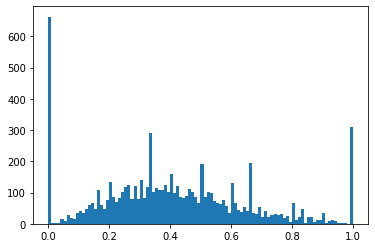

In [12]:
clust=nx.clustering(G)
plt.hist(clust.values(), bins=100)
plt.show()

Преимущественно, коэффициент принимает значения примерно от 0.15 до 0.7.

Количество вершин с нулевой и единичной кластеризацией:

In [29]:
print(f'{len(list(filter(lambda x: x == 0., clust.values())))} nodes with coefficient = 0.')
print(f'{len(list(filter(lambda x: x == 1., clust.values())))} nodes with coefficient = 1.')

663 nodes with coefficient = 0.
311 nodes with coefficient = 1.


### Коэффициент корреляции Пирсона степени и локального коэффициента кластеризации вершин.

In [38]:
from scipy.stats import pearsonr

In [43]:
degrees = G.degree()
d = []
for i in range(G.number_of_nodes()):
    d.append(degrees[f'{i}'])

print(f'Correlation: {pearsonr(d, list(clust.values()))[0]}')

Correlation: 0.016102904925237777


### Число компонент связности.

Проверка, связный ли граф

In [44]:
print(nx.is_connected(G))

True


Значит, всего 1 компонента связности.

$\textbf{Замечание.}$ В данном случае построение распределения размера компонент связности не имеет смысла, так как компонента всего одна.

## Распределение степеней и корреляция

### Распределение степеней.

Найдём степени всех вершин сети

In [45]:
degrees = [d for n, d in G.degree()]
print(np.mean(degrees))
print('Max degree:', np.max(degrees))
print('Min degree:', np.min(degrees)) 

25.352132634263853
Max degree: 697
Min degree: 1


In [46]:
def make_beautiful(ax):
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(4)
        ax.tick_params(width=4, direction = 'in', length = 8, pad=15)

    for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0.0)

    #ax.locator_params(axis='x', nbins=8)
    #ax.locator_params(axis='y', nbins=8)
    ax.tick_params(axis='x', which='major', labelsize=26)
    ax.tick_params(axis='y', which='major', labelsize=26)

    ax.xaxis.label.set_size(30)
    ax.yaxis.label.set_size(30)
    
    params = {'legend.fontsize': 18,
              'axes.titlesize': 30,
    }
    
    pylab.rcParams.update(params)

    return ax


def create_default_figure(a=16, b=12):
    fig, ax = plt.subplots(figsize = (a,b))
    ax = make_beautiful(ax)

    return fig, ax

Построим гистограмму распределения степеней

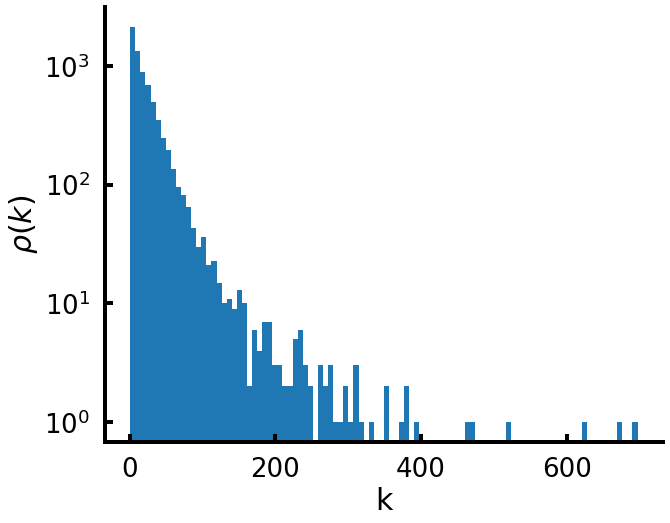

In [47]:
fig, ax = create_default_figure(10,8)
_ = ax.hist(degrees, bins=100, log=True)
ax.set_xlabel('k')
ax.set_ylabel(r'$\rho(k)$')
plt.show()

Сначала используем построение распределения в двойном логарифмическом масштабе и попробуем аппроксимировать его прямой.

In [48]:
h, x = np.histogram(degrees, bins=100, density=True) 

x_ = (x[:-1] + x[1:]) / 2  # координаты середины столбцов гистограммы

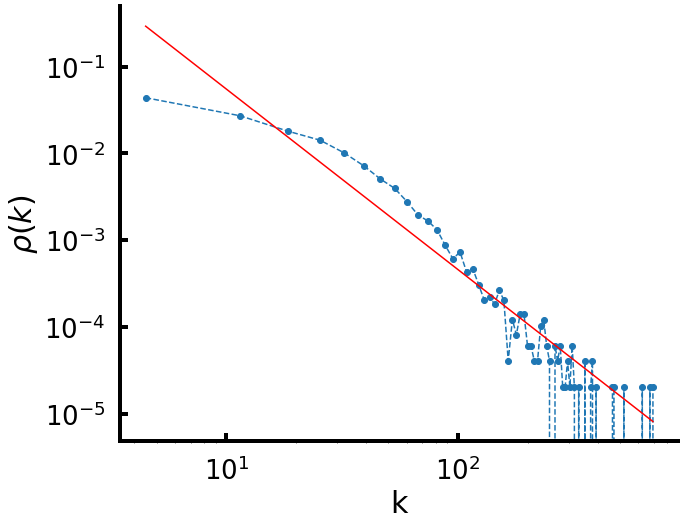

In [49]:
z = np.polyfit(np.log(x_[np.nonzero(h)]), np.log(h[np.nonzero(h)]), 1) 
f = np.poly1d(z)  

fig, ax = create_default_figure(10, 8)
ax.plot(x_, h,'o--')
ax.plot(x_, np.exp(f(np.log(x_))), color='r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('k')
ax.set_ylabel(r'$\rho(k)$')
plt.show()

По полученному графику нельзя сказать наверняка, подчиняется ли распределение степенному закону. Попробуем другой способ. Используем комплиментарную функцию:

[-2.36845886  6.9606852 ]


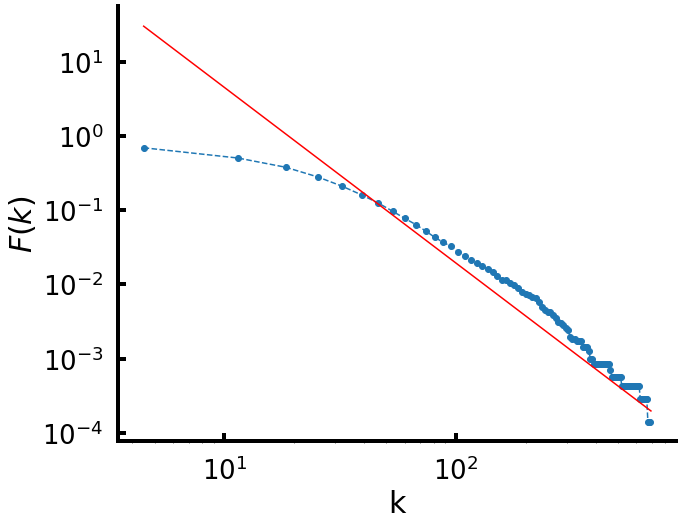

In [50]:
dx = x_[1] - x_[0]
ccdf = 1 - (np.cumsum(h)*dx)

fig, ax = create_default_figure(10, 8)
ax.plot(x_[:-1], ccdf[:-1], 'o--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('k')
ax.set_ylabel(r'$F(k)$')

z = np.polyfit(np.log(x_[:]), np.log(ccdf[:]), 1) # не используем последние 10 точек
f = np.poly1d(z)
ax.plot(x_, np.exp(f(np.log(x_))), color='red')
print(z)

Теперь используем библиотеку powerlaw.

In [51]:
import powerlaw

Calculating best minimal value for power law fit


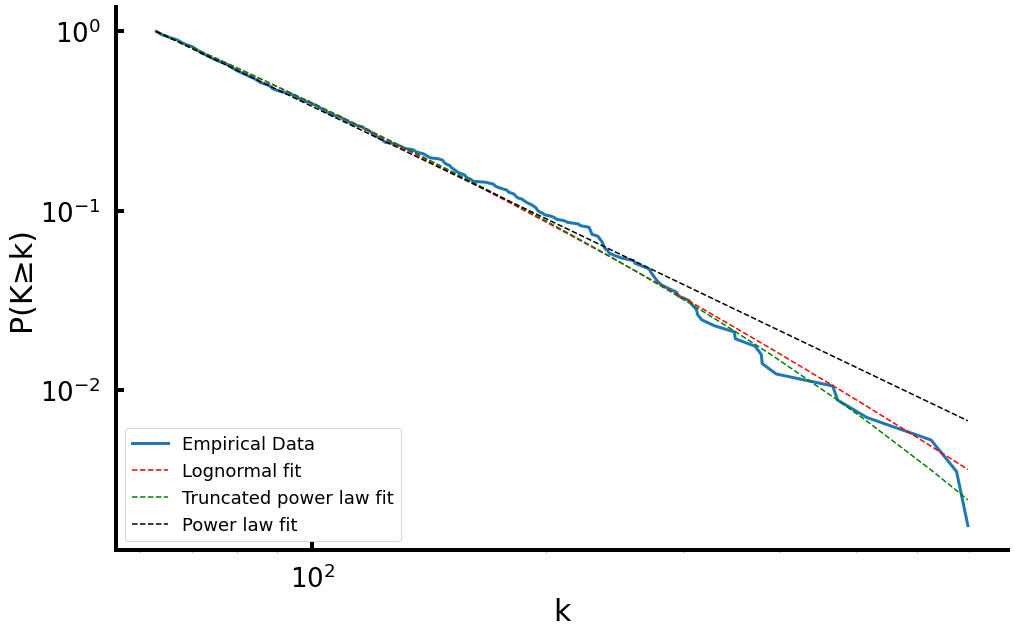

In [52]:
fig, ax = plt.subplots(figsize = (16,10))
ax = make_beautiful(ax)

fit = powerlaw.Fit(degrees, discrete=True)
####

fit.plot_ccdf(ax=ax, linewidth=3, label='Empirical Data')
fit.lognormal.plot_ccdf(ax=ax, color='r', linestyle='--', label='Lognormal fit')
fit.truncated_power_law.plot_ccdf(ax=ax, color='g', linestyle='--', label='Truncated power law fit')
fit.power_law.plot_ccdf(ax=ax, color='k', linestyle='--', label='Power law fit')

ax.set_ylabel(u"P(K≥k)")
ax.set_xlabel("k")
ax.legend(loc=3)

In [53]:
fit.distribution_compare('power_law', 'lognormal')

(-1.4134107738379234, 0.2771853845654295)

In [54]:
fit.distribution_compare('lognormal', 'truncated_power_law')

(-0.7851582402270614, 0.024115501137513616)

Получили, что с помощью приведенных методов не получилось выявить степенное распределение. Значит, что распределение степеней не подчиняется степенному закону.

### Ассортативность.

In [61]:
print(nx.degree_assortativity_coefficient(G))

0.029365859012146334


### Корреляции степеней

Как на семинаре с помощью метода average_neighbor_degree.

In [154]:
nn_degrees = nx.average_neighbor_degree(G)
degrees = [d for n, d in G.degree()]

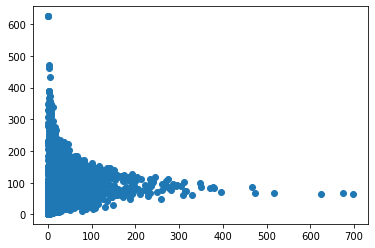

In [155]:
plt.scatter(degrees, nn_degrees.values())
plt.show()

Усреденение значения средней степени ближайших соседей вершин для каждого значения k.

In [156]:
test = dict()
for elem in set(degrees):
    count = 0
    s = 0
    for n, d in G.degree():
        if d == elem:
            count += 1
            s += nn_degrees[f'{n}']
    test[elem] = s/count

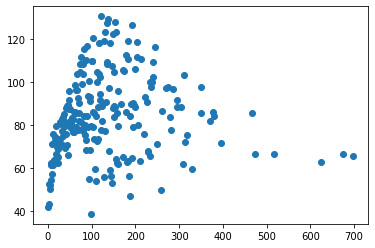

In [161]:
plt.scatter(list(set(degrees)), test.values())
plt.show()

### Зависимость коэффициента Rich Club от k.

$\textbf{Замечание.}$ 
К сожалению, из множества сетей я выбрал ту, в которой есть петли. Поэтому далее, так как метод rich_club_coefficient не работает с сетями, которые содержат петли, удалим петли из изначальной сети и изучим преобразованную сеть.

In [56]:
G.remove_edges_from(nx.selfloop_edges(G))

In [57]:
r_club = nx.rich_club_coefficient(G, normalized=False, seed=42)

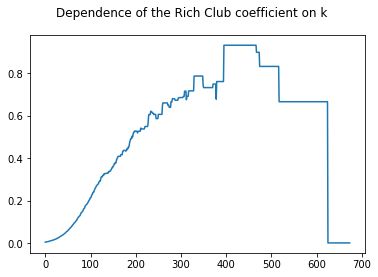

In [58]:
plt.plot(r_club.keys(), r_club.values())
plt.suptitle('Dependence of the Rich Club coefficient on k')
plt.show()

Получился крайне забавный, на мой взгляд, график.

### 4. Функция разложения сети по k-core

$\textbf{Замечание.}$ 
К сожалению, метод k_core также не работает с сетями, которые содержат петли, поэтому как и в предыдущем пункте удалим петли из изначальной сети и далее изучим преобразованную сеть.

In [59]:
G.remove_edges_from(nx.selfloop_edges(G))

In [61]:
def k_core_decomposition(G):
    """
    Function build the k-core decomposition of the network.
    
    Parameters
    ----------
    G: networkx.classes.graph.Graph
        Initial network.
    
    Returns
    -------
    decompose: 2D-array
        The first coordinate of each element of this array is k value,
        the second coordinate - the number of nodes in corresponding k-core.
    """
    
    decompose = []
    i = 1
    while True:
        kG = nx.k_core(G, k=i)
        if kG.number_of_nodes() == 0:
            break
        decompose.append((i, kG.number_of_nodes()))
        i += 1
    return decompose

In [62]:
decompose = k_core_decomposition(G)

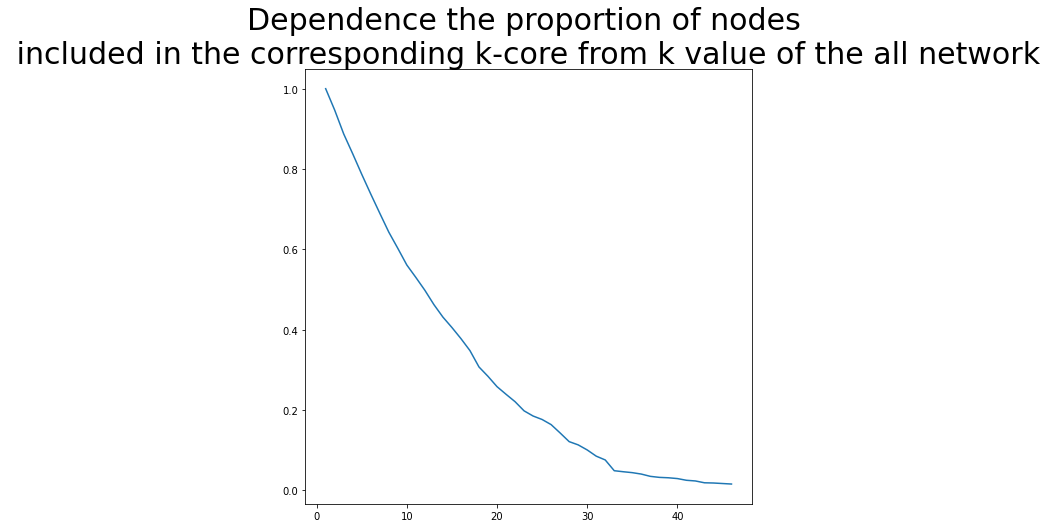

In [63]:
plt.figure(figsize=(8, 8))
plt.plot([decompose[i][0] for i in range(len(decompose))], [decompose[j][1]/G.number_of_nodes() for j in range(len(decompose))])
plt.title("Dependence the proportion of nodes \n included in the corresponding k-core from k value of the all network ")
plt.show()


## Моделирование и рандомизация

### Модели Эрдеша-Реньи, Барабаши-Альберта.

Для удобства ещё раз выведем основные свойства выбранной сети.

In [64]:
N = G.number_of_nodes()
Ed = G.number_of_edges()
p = 2 * Ed / (N * (N - 1))
print('Nodes:', N)
print('Edges:', Ed)
print('Density:', nx.density(G))
degrees_s = [d for node, d in G.degree()]
k = np.mean(degrees_s)
print('Average degree =',k)
print('P =',p)

Nodes: 7057
Edges: 89429
Density: 0.0035919450204152325
Average degree = 25.34476406404988
P = 0.0035919450204152325


#### Модель Эрдеша-Реньи

In [65]:
erd_ren = nx.erdos_renyi_graph(N, p, seed = 42) 

print('Number of edges =', erd_ren.number_of_edges())
print('Density:', nx.density(erd_ren))
degrees_erd = [d for node, d in erd_ren.degree()]
print('Average degree =', np.mean(degrees_erd))

Number of edges = 89177
Density: 0.003581823358033403
Average degree = 25.27334561428369


Сравним свойства с исходной моделью.

In [66]:
print(f'Diameter for initial graph: {nx.diameter(G)}')
print(f'Diameter for E-R: {nx.diameter(erd_ren)}')

Diameter for initial graph: 10
Diameter for E-R: 4


In [67]:
print('Average clustering coefficient for initial graph:', nx.average_clustering(G))
print('Average clustering coefficient E-R:', nx.average_clustering(erd_ren))

Average clustering coefficient for initial graph: 0.41088422622445286
Average clustering coefficient E-R: 0.0035375873099966287


In [68]:
degrees_init=[d for n, d in G.degree()]
degrees_erd=[d for n, d in erd_ren.degree()]

h_init, x_init = np.histogram(degrees_init, bins=100, density=True)
h_erd, x_erd = np.histogram(degrees_erd, bins=100, density=True)

x_init_=(x_init[:-1] + x_init[1:])/2
x_erd_=(x_erd[:-1] + x_erd[1:])/2

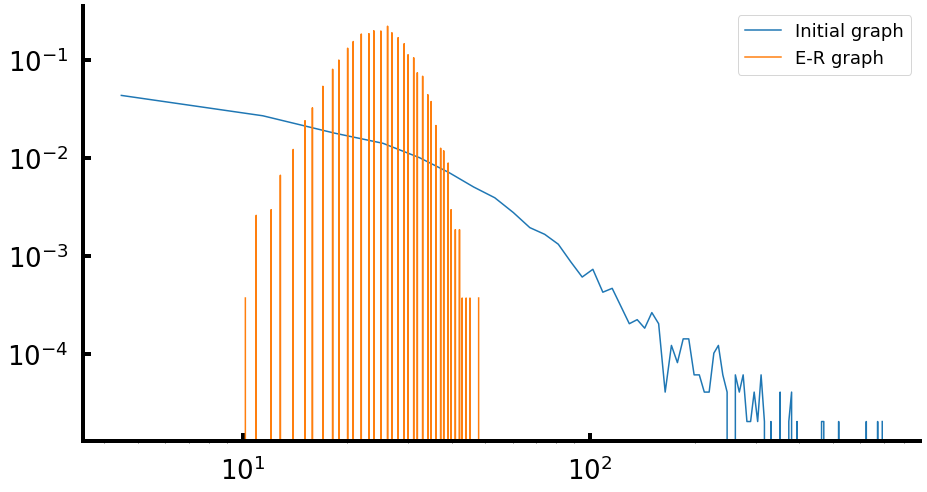

In [69]:
fig, ax = create_default_figure(15, 8)
ax.plot(x_init_, h_init, '-', label='Initial graph')
ax.plot(x_erd_, h_erd, '-', label='E-R graph')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
plt.show()

#### Модель Барабаши-Альберта

In [70]:
b_al = nx.barabasi_albert_graph(N, round(k/2))

print ('Number of edges =', b_al.number_of_edges())
degrees=[d for node, d in b_al.degree()]
print('Density:', nx.density(b_al))
print ('Average degree =', np.mean(degrees))

Number of edges = 91572
Density: 0.003678019315987696
Average degree = 25.95210429360918


Сравним свойства с исходной моделью.

In [71]:
print(f'Diameter for initial graph: {nx.diameter(G)}')
print(f'Diameter for B-A: {nx.diameter(b_al)}')

Diameter for initial graph: 10
Diameter for B-A: 4


In [72]:
print('Average clustering coefficient for initial graph:', nx.average_clustering(G))
print('Average clustering coefficient B-A:', nx.average_clustering(b_al))

Average clustering coefficient for initial graph: 0.41088422622445286
Average clustering coefficient B-A: 0.017231573600046752


In [73]:
degrees_b_al=[d for n, d in b_al.degree()]

h_b_al, x_b_al = np.histogram(degrees_b_al, bins=100, density=True)

x_b_al_=(x_b_al[:-1] + x_b_al[1:])/2

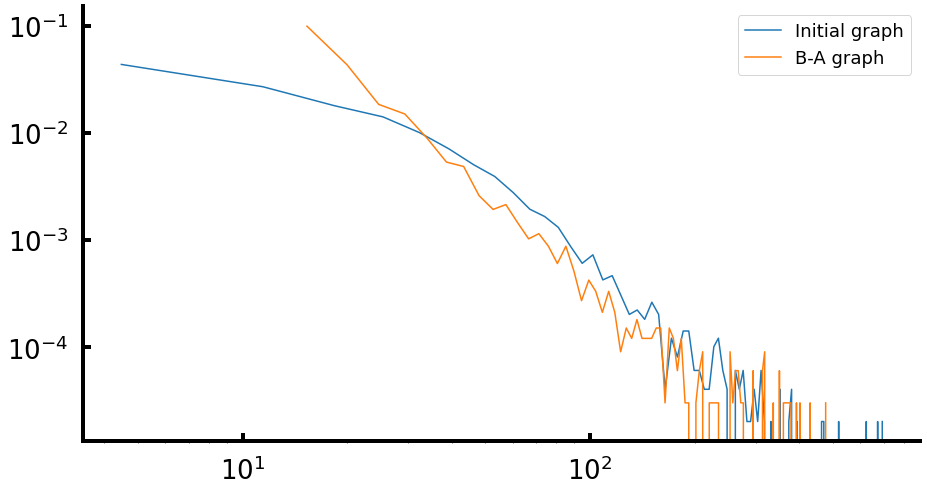

In [74]:
fig, ax = create_default_figure(15, 8)
ax.plot(x_init_, h_init, '-', label='Initial graph')
ax.plot(x_b_al_, h_b_al, '-', label='B-A graph')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
plt.show()

Получилось, что с точки зрения распределения степеней наилучшим образом исходную модель описывает модель Барабаши-Альберта. Это видно из построенных графиков. Если сравнивать по другим указанным параметрам, то обе модели заметно отличаются от исходной. Поэтому логично сделать вывод, что исходную сеть лучше описывает модель Барабаши-Альберта.

### Конфигурационная модель

In [82]:
import collections
import pandas as pd

In [77]:
degrees_sorted = list(dict(collections.OrderedDict(sorted({int(k):int(v) for k, v in dict(G.degree()).items()}.items()))).values())

In [78]:
cmg = nx.configuration_model(degrees_sorted, seed=10)

In [79]:
print(f'Number of self-loops: {len(list(nx.selfloop_edges(cmg)))}')

Number of self-loops: 44


In [93]:
cmg.remove_edges_from(nx.selfloop_edges(cmg))

In [94]:
s = []
for a, b, c in list(cmg.edges):
    if a < b:
        ts = f'{a},{b}'
    else:
        ts = f'{b},{a}'
    s.append(ts)
df = pd.DataFrame(s)
c = df.pivot_table(index = 0, aggfunc ='size')

counter = 0
for i in range(c.shape[0]):
    if c.iloc[i] > 1:
        counter += 1
print(f'Number of multi-edges: {counter}')

Number of multi-edges: 1323


In [95]:
cmg_simple = nx.Graph(cmg)

print(f'Number of edges in configuration model: {len(cmg.edges)}')
print(f'Number of edges in simplified configuration model: {len(cmg_simple.edges)}')
print(f'Transitivity coefficient of configuration model: {nx.transitivity(cmg_simple)}')
print(f'Average clustering coefficient of configuration model: {nx.average_clustering(cmg_simple)}')

Number of edges in configuration model: 89385
Number of edges in simplified configuration model: 87997
Transitivity coefficient of configuration model: 0.027423636183034953
Average clustering coefficient of configuration model: 0.02944242648670413


In [99]:
degrees_cmg=[d for n, d in cmg_simple.degree()]

h_cmg, x_cmg = np.histogram(degrees_cmg, bins=100, density=True)

x_cmg_=(x_cmg[:-1] + x_cmg[1:])/2

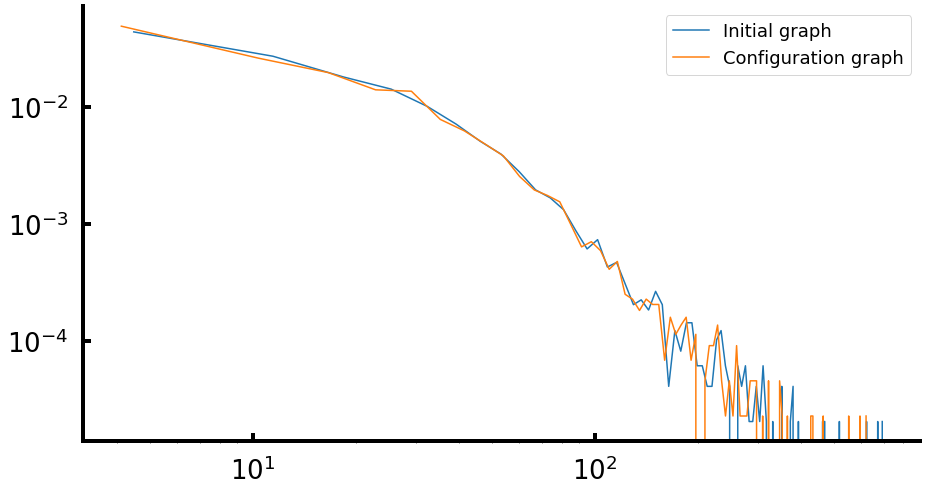

In [101]:
fig, ax = create_default_figure(15, 8)
ax.plot(x_init_, h_init, '-', label='Initial graph')
ax.plot(x_cmg_, h_cmg, '-', label='Configuration graph')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
plt.show()

Полученная конфигурационная модель лучше справляется с описанием кластеризации исходной модели.
Это видно из сравнения полученных графиков для конфигурационной модели и моделей Эрдеша-Реньи и Барабаши-Альберта.

### Функция Q шагов рандомизации и зависимость транзитивности от числа рандомизации

In [104]:
from tqdm import trange

In [105]:
def randomization(G, Q):
    tr = []
    for step in trange(Q):
        GR = nx.random_reference(G, step, seed=42, connectivity=False)
        tr.append(nx.transitivity(GR))
    return tr

In [108]:
tr_list = randomization(G, 15)

100%|██████████| 15/15 [03:36<00:00, 14.42s/it]


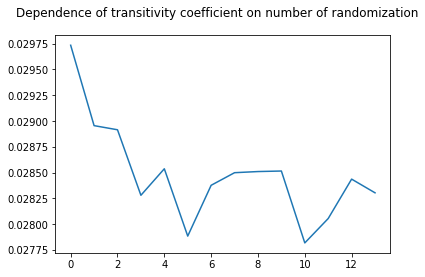

In [110]:
plt.clf()
plt.plot(tr_list[1:])
plt.suptitle('Dependence of transitivity coefficient on number of randomization')
plt.show()